In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
import random


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, DQN
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.cache import save_vtk_streamlines

from dfibert.envs._state import TractographyState

import matplotlib.pyplot as plt
%matplotlib notebook

#from train import load_model

In [3]:
import importlib
importlib.reload(RLTe)

<module 'dfibert.envs.RLtractEnvironment' from '../dfibert/envs/RLtractEnvironment.py'>

In [3]:
env = RLTe.RLtractEnvironment(stepWidth=0.8, action_space=100, device = 'cpu', 
                              pReferenceStreamlines='/bigdata/hplsim/aipp/RLtract/deepFibreTracking/examples/data/dti_ijk_0.8_maxDirecGetter.vtk', 
                              tracking_in_RAS = False, odf_state = False)
n_actions = env.action_space.n

Loading precomputed streamlines (/bigdata/hplsim/aipp/RLtract/deepFibreTracking/examples/data/dti_ijk_0.8_maxDirecGetter.vtk) for ID 100307
sphere_odf = sphere_action = repulsion100
Computing ODF


In [4]:
env._init_shmcoeff()
print(env.shcoeff.shape)

(145, 174, 145, 45)


In [6]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
ijk_pts = env.grid + state.getCoordinate().cpu().detach().numpy()

(3, 3, 3, 3)


In [3]:
import dipy.reconst.dti as dti
dti_model = dti.TensorModel(env.dataset.data.gtab, fit_method='LS')
dti_fit = dti_model.fit(env.dataset.data.dwi, mask=env.dataset.data.binarymask)

# compute ODF
odf = dti_fit.odf(env.sphere_odf)
pmf = odf.clip(min=0)

In [4]:
print(pmf.shape)

(145, 174, 145, 100)


In [8]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
pmf_cur = env.pmf_gen.get_pmf(state.getCoordinate().double().squeeze(0).numpy())
reward = pmf_cur / np.max(pmf_cur)
print(np.argmax(reward))

93


In [52]:
shcoeff_action = []
action = None
for i in range(len(env.referenceStreamline_ijk)-1):
    pmf = env.interpolatePMFatState(env.referenceStreamline_ijk[i].double().numpy())
    if action is not None:
    #    pmf[pmf < 0.1] = 0
        last_direction = env.directions[action].view(3).numpy()
        cdf = env._adj_matrix[tuple(last_direction)] * pmf
        action = np.argmax(cdf)
    else:
        _, _, action = peak_directions(pmf, env.sphere)
        action = action[0]
    #shcoeff_action.append(action)
    #action = np.argmax(pmf)
    shcoeff_action.append(action)
    
print(shcoeff_action)

[47, 39, 97, 34, 42, 46, 41, 41, 41, 33]


In [8]:
from dipy.direction.peaks import peak_directions

In [51]:
odf_action = []
action = None
for i in range(len(env.referenceStreamline_ijk)-1):
    pmf = (env.interpolateODFatState(stateCoordinates=env.referenceStreamline_ijk[i])[:,1,1,1])
    if action is not None:
        #pmf[pmf < 0.1] = 0
        last_direction = env.directions[action].view(3).numpy()
        cdf = env._adj_matrix[tuple(last_direction)] * pmf
        action = np.argmax(cdf)
    else:
        _, _, action = peak_directions(pmf, env.sphere)
        action = action[0]
    #
    #action = np.argmax(pmf)
    odf_action.append(action)
    
print(odf_action)

[97, 39, 34, 34, 42, 46, 91, 91, 41, 33]


In [53]:
print(env.directions[shcoeff_action])
print(env.directions[odf_action])

tensor([[ 0.9555, -0.2809,  0.0905],
        [ 0.7840, -0.6188,  0.0487],
        [-0.9555,  0.2809, -0.0905],
        [ 0.9292, -0.0795,  0.3610],
        [ 0.9379,  0.2621,  0.2271],
        [-0.9068, -0.4049,  0.1173],
        [-0.6833, -0.7184,  0.1302],
        [-0.6833, -0.7184,  0.1302],
        [-0.6833, -0.7184,  0.1302],
        [-0.6940, -0.5697,  0.4403]], dtype=torch.float64)
tensor([[-0.9555,  0.2809, -0.0905],
        [ 0.7840, -0.6188,  0.0487],
        [ 0.9292, -0.0795,  0.3610],
        [ 0.9292, -0.0795,  0.3610],
        [ 0.9379,  0.2621,  0.2271],
        [-0.9068, -0.4049,  0.1173],
        [ 0.6833,  0.7184, -0.1302],
        [ 0.6833,  0.7184, -0.1302],
        [-0.6833, -0.7184,  0.1302],
        [-0.6940, -0.5697,  0.4403]], dtype=torch.float64)


In [54]:
for i in range(len(env.referenceStreamline_ijk)-1):
    pmf_from_odf = env.interpolateODFatState(stateCoordinates=env.referenceStreamline_ijk[i])[:,1,1,1]
    pmf_from_sh = env.interpolatePMFatState(env.referenceStreamline_ijk[i].double().numpy())
    
    print(i, gt_actions[i])
    print("ODF: ground-truth value: ", pmf_from_odf[gt_actions[i]], ", max: ", np.max(pmf_from_odf), ", index: ", np.argmax(pmf_from_odf))
    print("SH: ground-truth value: ", pmf_from_sh[gt_actions[i]], ", max: ", np.max(pmf_from_sh), ", index: ", np.argmax(pmf_from_sh))
    print("cosine similarity: odf: ", torch.nn.functional.cosine_similarity(env.directions[gt_actions[i]], env.directions[np.argmax(pmf_from_odf)], dim=0).numpy(), \
          ", sh: ", torch.nn.functional.cosine_similarity(env.directions[gt_actions[i]], env.directions[np.argmax(pmf_from_sh)], dim=0).numpy())
    print()

0 tensor(89)
ODF: ground-truth value:  0.07025151472668065 , max:  0.2083056523948617 , index:  97
SH: ground-truth value:  0.07651210435478413 , max:  0.18717188232323784 , index:  47
cosine similarity: odf:  0.927317149784872 , sh:  -0.927317149784872

1 tensor(97)
ODF: ground-truth value:  0.05577069505822985 , max:  0.06664159074558873 , index:  39
SH: ground-truth value:  0.056053058188785775 , max:  0.06588572586139903 , index:  39
cosine similarity: odf:  -0.927317149784872 , sh:  -0.927317149784872

2 tensor(84)
ODF: ground-truth value:  0.08455187126388458 , max:  0.08455187126388458 , index:  34
SH: ground-truth value:  0.08438419717861002 , max:  0.08444315032035168 , index:  97
cosine similarity: odf:  -1.0 , sh:  0.9427988734326452

3 tensor(92)
ODF: ground-truth value:  0.09954268080953793 , max:  0.10084170898446602 , index:  34
SH: ground-truth value:  0.0995375759969714 , max:  0.10084750351698793 , index:  34
cosine similarity: odf:  -0.9326351000205255 , sh:  -0.9326

In [38]:
state = env.reset(streamline_index=4, start_middle_of_streamline=False, start_index=0)
gt_actions = []
for i in range(len(env.referenceStreamline_ijk)-1):
    gt_vector = (env.referenceStreamline_ijk[i+1] - env.referenceStreamline_ijk[i]).view(1,3)
    action = torch.argmax(torch.nn.functional.cosine_similarity(env.directions, gt_vector))
    gt_actions.append(action)
    
print(gt_actions)

[tensor(89), tensor(97), tensor(84), tensor(92), tensor(46), tensor(41), tensor(41), tensor(41), tensor(33), tensor(33)]


cur_tangent:  tensor([ 0.8961, -0.3757, -0.2365], dtype=torch.float64)
cur_tangent after correction:  tensor([[ 0.8961, -0.3757, -0.2365]], dtype=torch.float64)
next_position in step:  tensor([[24.5447, 77.4656, 50.3005]], dtype=torch.float64)
cur_tangent:  tensor([ 0.9106, -0.0751, -0.4064], dtype=torch.float64)
cur_tangent after correction:  tensor([[ 0.9106, -0.0751, -0.4064]], dtype=torch.float64)
next_position in step:  tensor([[25.2732, 77.4055, 49.9754]], dtype=torch.float64)
cur_tangent:  tensor([ 0.4010,  0.6996, -0.5913], dtype=torch.float64)
cur_tangent after correction:  tensor([[ 0.4010,  0.6996, -0.5913]], dtype=torch.float64)
next_position in step:  tensor([[25.5940, 77.9652, 49.5023]], dtype=torch.float64)
cur_tangent:  tensor([ 0.4010,  0.6996, -0.5913], dtype=torch.float64)
cur_tangent after correction:  tensor([[ 0.4010,  0.6996, -0.5913]], dtype=torch.float64)
next_position in step:  tensor([[25.9148, 78.5249, 49.0293]], dtype=torch.float64)
cur_tangent:  tensor([ 0

<IPython.core.display.Javascript object>


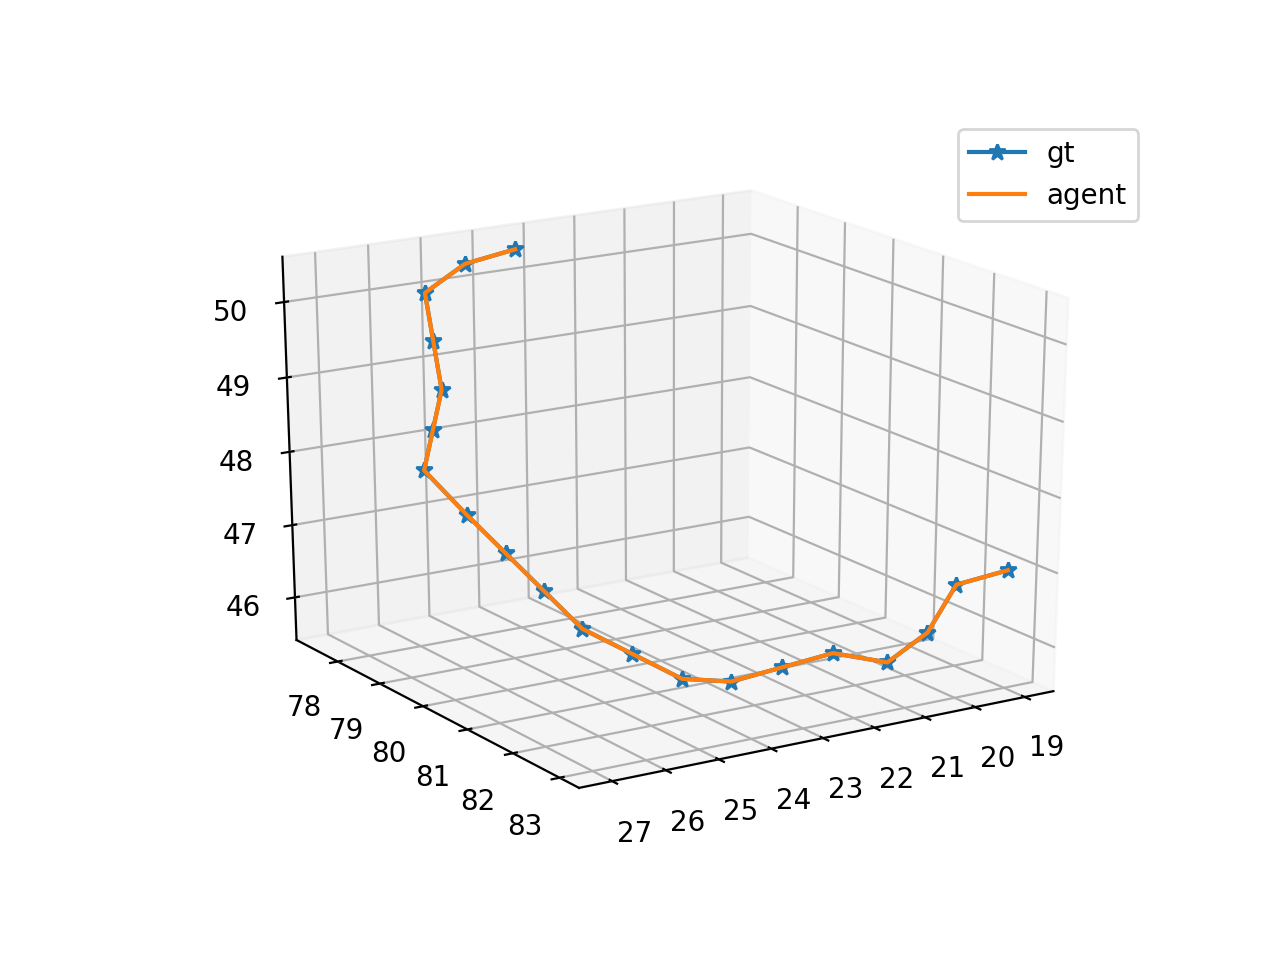

In [34]:
terminal = False
all_states = []
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
current_direction = None
all_states.append(state.getCoordinate())
for i in range(len(gt_actions)):
    #my_position = state.getCoordinate().double().squeeze(0)
    #print(action)
    #action = env._get_best_action(current_direction, my_position.numpy())
    #current_direction = env.directions[action].numpy()
    action = gt_actions[i]
    state, reward, terminal, _  = env.step(action)
    all_states.append(state.getCoordinate().squeeze(0))
    
    
%matplotlib notebook
states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

20
cur_tangent:  tensor([-0.8961,  0.3757,  0.2365], dtype=torch.float64)
cur_tangent after correction:  tensor([[ 0.8961, -0.3757, -0.2365]], dtype=torch.float64)
next_position in step:  tensor([[24.5447, 77.4656, 50.3005]], dtype=torch.float64)
43
cur_tangent:  tensor([-0.8961,  0.3757,  0.2365], dtype=torch.float64)
cur_tangent after correction:  tensor([[ 0.8961, -0.3757, -0.2365]], dtype=torch.float64)
next_position in step:  tensor([[25.2616, 77.1651, 50.1114]], dtype=torch.float64)
43
cur_tangent:  tensor([-0.9106,  0.0751,  0.4064], dtype=torch.float64)
cur_tangent after correction:  tensor([[ 0.9106, -0.0751, -0.4064]], dtype=torch.float64)
next_position in step:  tensor([[25.9900, 77.1050, 49.7863]], dtype=torch.float64)
30
Terminal due to too low fa.  [0.01913803]


<IPython.core.display.Javascript object>


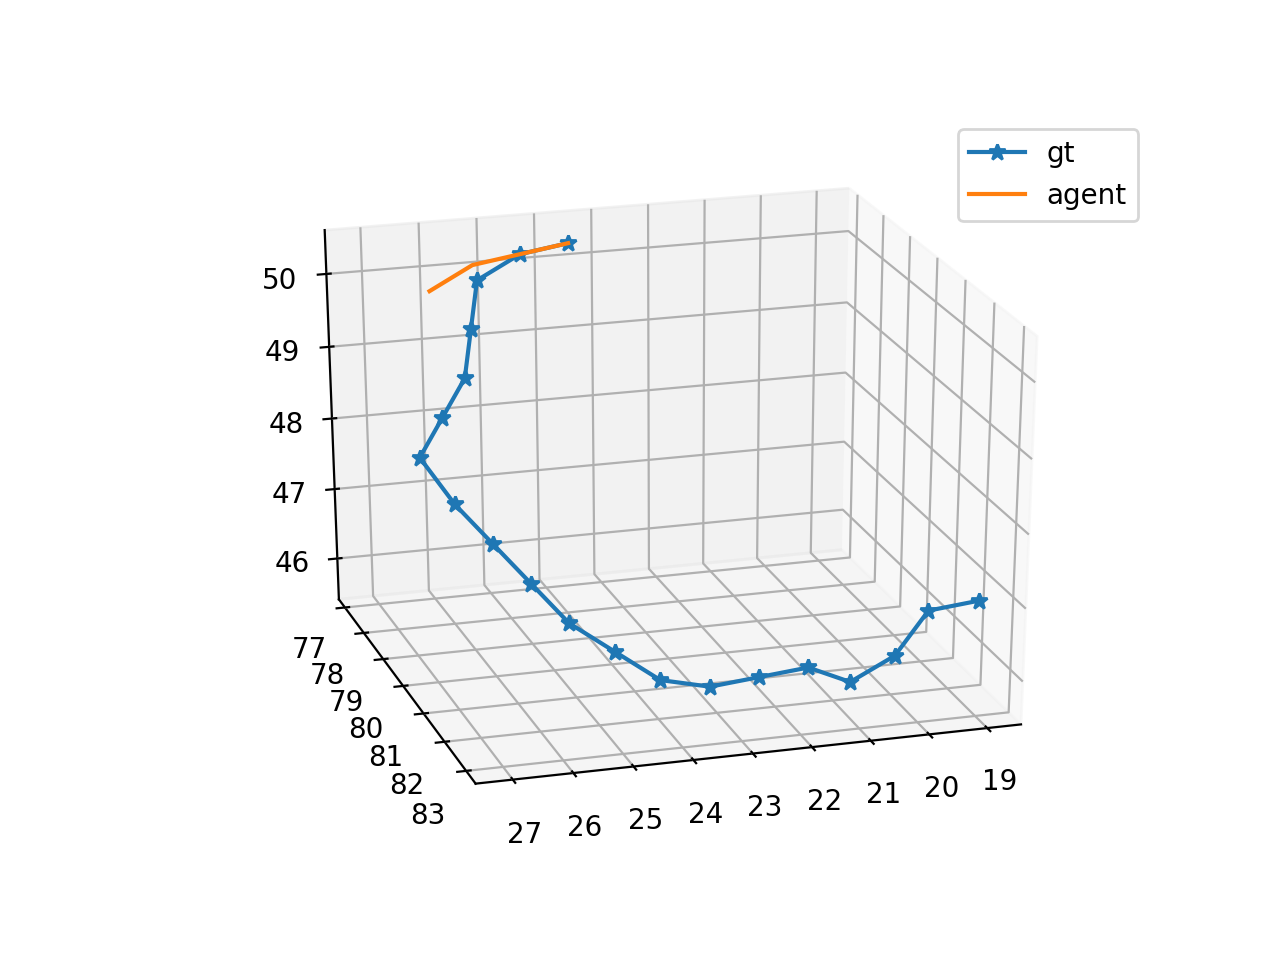

In [8]:
terminal = False
all_states = []
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
current_direction = None
while not terminal:
    my_position = state.getCoordinate().double().squeeze(0)
    all_states.append(my_position)
    print(action)
    action = env._get_best_action(current_direction, my_position.numpy())
    current_direction = env.directions[action].numpy()
    state, reward, terminal, _  = env.step(action)
    
    
%matplotlib notebook
states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

## Ground-truth directions from PMF

In [49]:
from dipy.direction import DeterministicMaximumDirectionGetter
dg = DeterministicMaximumDirectionGetter.from_pmf(pmf=env.pmf, max_angle=80, sphere=env.sphere_odf)

In [50]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
my_position = state.getCoordinate().double().squeeze(0).numpy()
current_direction = dg.initial_direction(my_position)
next_position = my_position + env.stepWidth * current_direction
print(state.getCoordinate().numpy(), "=>", next_position, current_direction)

[23.827818 77.76611  50.489697] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]]


In [51]:
current_direction = current_direction.squeeze(0)
next_position = next_position.squeeze(0)

In [64]:
next_position = my_position + env.stepWidth * current_direction
print(current_direction, next_position)
current_direction = current_direction
status = dg.get_direction(next_position, current_direction)
print(status, current_direction)

[ 0.89608922 -0.3756509  -0.23645403] [24.54468929 77.46559256 50.30053328]
0 [ 0.89608922 -0.3756509  -0.23645403]


[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.8278

<IPython.core.display.Javascript object>


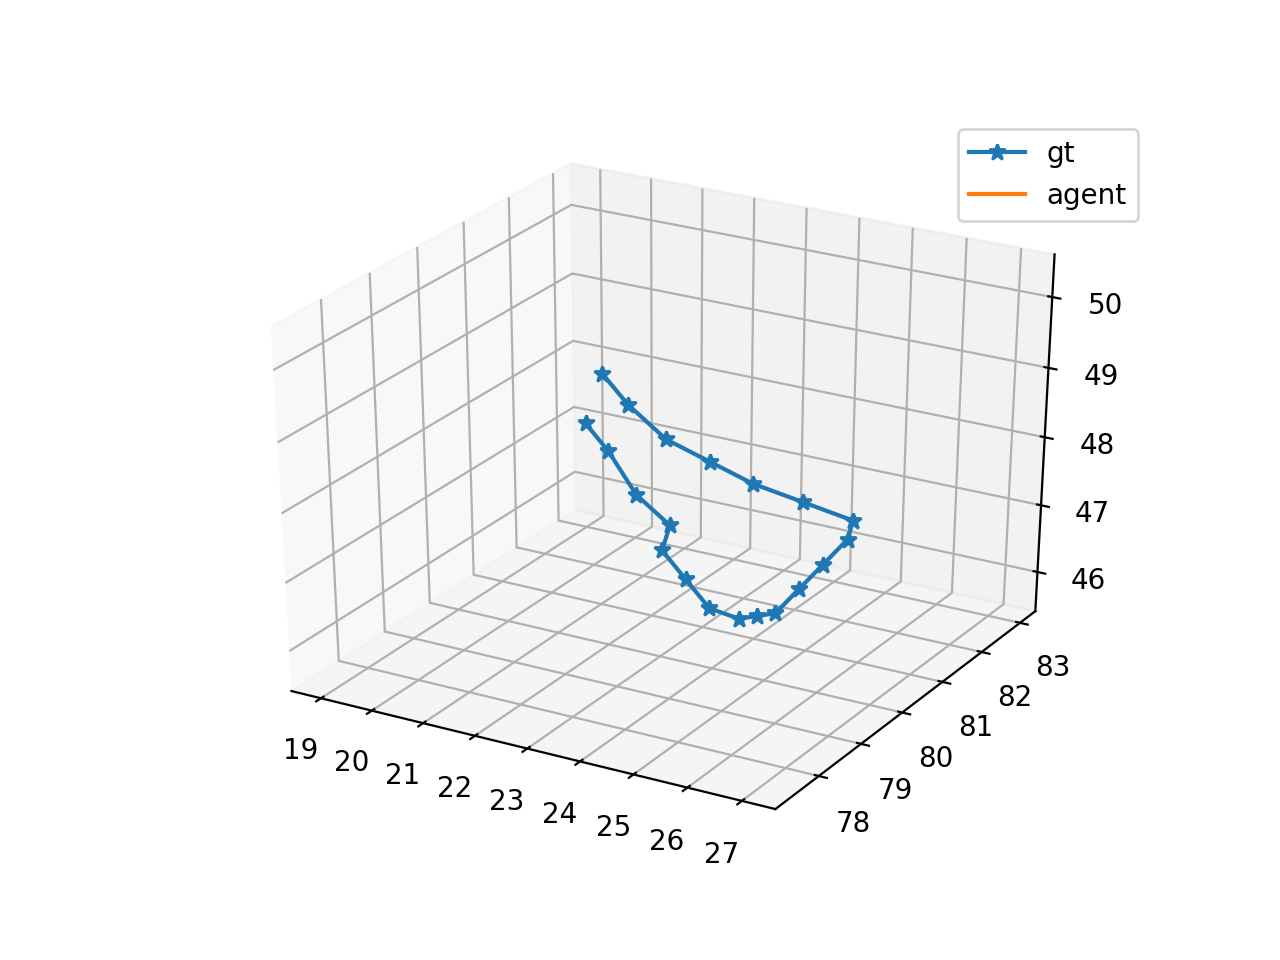

In [33]:
terminal = False
all_states = []
all_directions = []
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
my_position = state.getCoordinate().double().squeeze(0).numpy()
current_direction = dg.initial_direction(my_position)
#action = np.where(env.sphere.vertices == current_direction)[0][0]

for i in range(len(env.referenceStreamline_ijk)):
    #print(my_position, "=>", state.getCoordinate().numpy(), action, reward)
    #my_position = state.getCoordinate().double().squeeze(0)
    all_states.append(my_position)
    all_directions.append(current_direction)
    
    dg.
    next_position = my_position + env.stepWidth * current_direction
    
    dg.get_direction(next_position.squeeze(0).numpy(), current_direction.squeeze(0))
    action = np.where(env.sphere.vertices == current_direction)[0][0]
    #state, reward, terminal, _  = env.step(action)
    print(my_position.numpy(), "=>", next_position.numpy(), current_direction, action)
    
%matplotlib notebook
states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

### Load pretrained agent and analyse its behaviour

In [3]:
streamline_index = 1
device = "cpu"
max_steps = 30000000
replay_memory_size = 100000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 10000
start_learning = 10000
eps_annealing_steps = 400000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 512
learning_rate = 0.000001 


state = env.reset(streamline_index=streamline_index, start_index=-2, start_middle_of_streamline=False)
env.referenceStreamline_ijk, state.getCoordinate()

(tensor([[23.8278, 77.7661, 50.4897],
         [24.5447, 77.4656, 50.3005],
         [25.2732, 77.4055, 49.9754],
         [25.5940, 77.9652, 49.5023],
         [25.9148, 78.5249, 49.0293],
         [26.4700, 78.9807, 48.6771],
         [27.0251, 79.4365, 48.3248],
         [26.6042, 79.8737, 47.8037],
         [26.0320, 80.0483, 47.2726],
         [25.4597, 80.2229, 46.7414],
         [24.8875, 80.3975, 46.2103],
         [24.2499, 80.7637, 45.8952],
         [23.6123, 81.1300, 45.5801],
         [22.8479, 81.3547, 45.5077],
         [22.1310, 81.6552, 45.6968],
         [21.4142, 81.9557, 45.8860],
         [21.0027, 82.6414, 45.9119],
         [20.2743, 82.7014, 46.2370],
         [19.7169, 82.6995, 46.8108],
         [19.0000, 83.0000, 47.0000]]),
 tensor([19.7169, 82.6995, 46.8108]))

In [5]:
# this agent got DWI input data and then predicts the direction out of 20 possible actions
# reward: odf20
model, step_counter, mean_reward, epsilon = load_model('defi_2.86_dwi_odf100.pt')

#model, step_counter, mean_reward, epsilon = load_model('defi_4.95_dwi_odf20.pt')
agent = Agent(n_actions=20, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
              agent_history_length=agent_history_length, 
              memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

agent.main_dqn.load_state_dict(model)
agent.target_dqn.load_state_dict(model)

Loading checkpoint from defi_2.86_dwi_odf100.pt


<All keys matched successfully>

In [6]:
if(False):
    # this agent got ODF input data and then predicts the direction out of 100 possible actions
    # reward: odf20
    model, step_counter, mean_reward, epsilon = load_model('defi_4.81_odf20state_odf20.pt')
    agent = Agent(n_actions=20, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
                  agent_history_length=agent_history_length, 
                  memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

    agent.main_dqn.load_state_dict(model)
    agent.target_dqn.load_state_dict(model)

In [4]:
agent = Agent(n_actions=100, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
              agent_history_length=agent_history_length, 
              memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

In [25]:
odf_peaks = torch.mean(torch.from_numpy(env.interpolateODFatState(stateCoordinates=my_position)), dim=1)
print(odf_peaks)

tensor([[[0.0702, 0.0538, 0.0764],
         [0.0715, 0.0613, 0.0742],
         [0.0530, 0.0675, 0.0631]],

        [[0.0703, 0.0548, 0.0784],
         [0.0728, 0.0663, 0.0811],
         [0.0551, 0.0735, 0.0715]],

        [[0.0712, 0.0569, 0.0789],
         [0.0728, 0.0662, 0.0803],
         [0.0543, 0.0687, 0.0602]],

        [[0.0696, 0.0517, 0.0750],
         [0.0714, 0.0597, 0.0722],
         [0.0539, 0.0701, 0.0705]],

        [[0.0725, 0.0606, 0.0819],
         [0.0756, 0.0744, 0.0879],
         [0.0579, 0.0761, 0.0677]],

        [[0.0721, 0.0581, 0.0774],
         [0.0735, 0.0651, 0.0745],
         [0.0546, 0.0664, 0.0582]],

        [[0.0700, 0.0537, 0.0772],
         [0.0736, 0.0669, 0.0791],
         [0.0577, 0.0773, 0.0795]],

        [[0.0731, 0.0615, 0.0809],
         [0.0752, 0.0719, 0.0824],
         [0.0571, 0.0712, 0.0581]],

        [[0.0715, 0.0554, 0.0754],
         [0.0727, 0.0608, 0.0695],
         [0.0540, 0.0665, 0.0622]],

        [[0.0722, 0.0601, 0.0820],
  

In [16]:
odf_peaks = torch.from_numpy(env.interpolateODFatState(stateCoordinates=my_position))
similarities = torch.nn.functional.cosine_similarity(env.directions, odf_peaks)
print(similarities)

RuntimeError: The size of tensor a (100) must match the size of tensor b (3) at non-singleton dimension 2

odf_cur:  tensor([0.0457, 0.0467, 0.0463, 0.0459, 0.0491, 0.0457, 0.0470, 0.0470, 0.0455,
        0.0483, 0.0479, 0.0461, 0.0484, 0.0461, 0.0485, 0.0466, 0.0457, 0.0495,
        0.0463, 0.0471, 0.0473, 0.0461, 0.0510, 0.0466, 0.0461, 0.0495, 0.0472,
        0.0482, 0.0471, 0.0461, 0.0507, 0.0474, 0.0466, 0.0482, 0.0472, 0.0500,
        0.0468, 0.0468, 0.0492, 0.0609, 0.0472, 0.0474, 0.0473, 0.0938, 0.0471,
        0.0466, 0.0483, 0.0489, 0.0481, 0.0468, 0.0457, 0.0467, 0.0463, 0.0459,
        0.0491, 0.0457, 0.0470, 0.0470, 0.0455, 0.0483, 0.0479, 0.0461, 0.0484,
        0.0461, 0.0485, 0.0466, 0.0457, 0.0495, 0.0463, 0.0471, 0.0473, 0.0461,
        0.0510, 0.0466, 0.0461, 0.0495, 0.0472, 0.0482, 0.0471, 0.0461, 0.0507,
        0.0474, 0.0466, 0.0482, 0.0472, 0.0500, 0.0468, 0.0468, 0.0492, 0.0609,
        0.0472, 0.0474, 0.0473, 0.0938, 0.0471, 0.0466, 0.0483, 0.0489, 0.0481,
        0.0468], dtype=torch.float64)
reward:  tensor([0.4876, 0.4976, 0.4932, 0.4892, 0.5230, 0.4871, 0.5006,

<IPython.core.display.Javascript object>


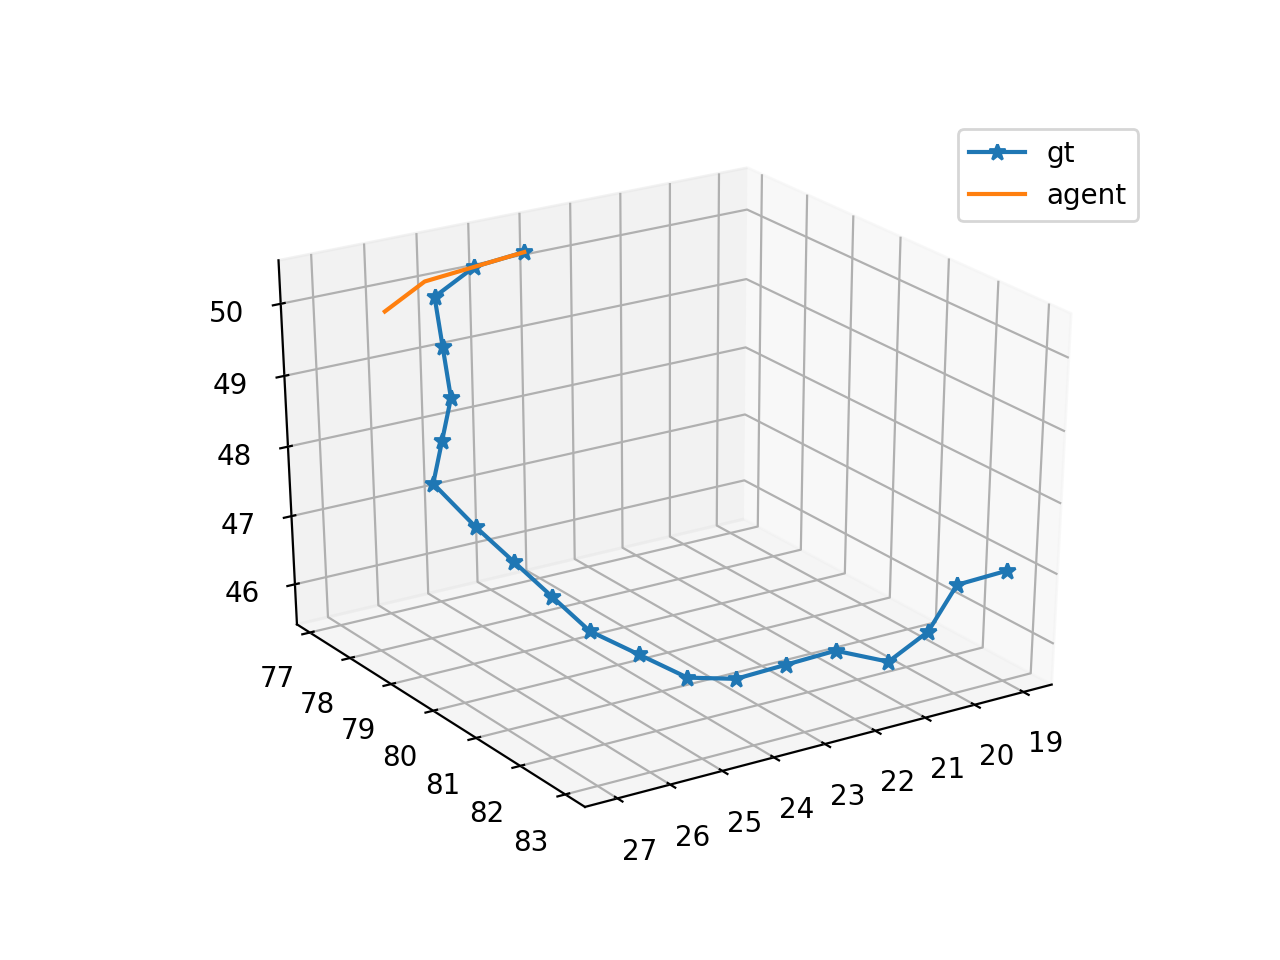

In [7]:
eval_rewards = []
all_distances = []
all_states = []
l2s = []
max_episode_length = 20
fa_threshold = 0.1
K = 3

#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    state = env.reset(streamline_index=streamline_index, start_middle_of_streamline=False, start_index=0)
    next_state = state
    all_states.append(state.getCoordinate())
    eval_episode_reward = 0
    episode_final = 0
    current_direction = None
    while eval_steps < max_episode_length:
        
        #with torch.no_grad():
        #    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
        #    action = torch.argmax(agent.main_dqn(state_v)).item()
        
        my_position = all_states[-1]
        
        
       # if(eval_steps > 0):
       #     # compute tangent of previous step
       #     current_direction = all_states[-1] - all_states[-2]
       #     current_direction = current_direction / torch.sqrt(torch.sum(current_direction**2))
       #     current_direction = current_direction.view(1,3)
       #     
       #     print(current_direction)
       #     print(env.directions[action])
       #     same ---> therefore sticking to env.directions[action]
        #current_direction = env.directions[action].view(1,3)
        
        #action = get_multi_best_action(current_direction, odf_interpolator, my_position, mysphere, sphere_verts_torch, K = K)
        action = env._get_best_action(current_direction, my_position)
        
        
        next_state, reward, terminal, _ = env.step(action)
        
        #reward = reward
        
        print(eval_steps, my_position, "=>", next_state.getCoordinate().numpy(), action, reward)

        
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate().squeeze())
                
        state = next_state
        print("---")
        if terminal:
            terminal = False
            break
            
        eval_episode_reward += reward
        eval_steps += 1

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))

########################
### visualise streamline
########################
%matplotlib notebook 
state = env.reset(streamline_index=streamline_index) 

states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

In [ ]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
all_states.append(state.getCoordinate())

#peak_indices = peaks_from_model(
#    model=dti_model, data=env.dataset.data.dwi, sphere=mysphere, relative_peak_threshold=.2,
#    min_separation_angle=25, mask=env.dataset.data.binarymask, npeaks=2) # Peaks and Metrics object


for i in range(len(env.referenceStreamline_ijk)-1):
    odf = torch.from_numpy(env.interpolateODFatState(stateCoordinates=env.referenceStreamline_ijk[i]))[:,1,1,1].view(100)
    pmf = env.interpolatePMFatState(env.referenceStreamline_ijk[i].double().numpy())
    action = torch.argmax(odf)
    
    gt_direction = env.referenceStreamline_ijk[i+1] - env.referenceStreamline_ijk[i]
    gt_direction = (gt_direction / torch.sqrt(torch.sum(gt_direction**2))).view(1,3)
    
    gt_action = torch.argmax(torch.nn.functional.cosine_similarity(gt_direction, env.directions))
    
    next_state, reward, terminal, _ = env.step(action)
    all_states.append(next_state.getCoordinate().squeeze())
    
    print("Step: ", i)
    print("ODF gt: ", odf[gt_action].item())
    print("max ODF: ", torch.max(odf).item())
    print("PMF gt: ", pmf[gt_action])
    print("max PMF: ", np.max(pmf))
    print("action: ", action)
    

states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

In [22]:
gt_direction.shape

torch.Size([3])

### Debug deterministic tracking of Dipy

In [57]:
from scipy.interpolate import RegularGridInterpolator
import dipy.reconst.dti as dti

from dipy.direction import peaks_from_model
from dipy.data import get_sphere


# fit DTI model to data
dti_model = dti.TensorModel(env.dataset.data.gtab, fit_method='LS')
dti_fit = dti_model.fit(env.dataset.data.dwi, mask=env.dataset.data.binarymask)

#TODO: Issue => are we using the correct data for tractography actually??? The data got 288 gradient directions
# seems like its using the data of all bvals!!!
mysphere = get_sphere('repulsion100')
odf = dti_fit.odf(mysphere)

## set up interpolator for directions
x_range = np.arange(odf.shape[0])
y_range = np.arange(odf.shape[1])
z_range = np.arange(odf.shape[2])



#affine = env.dataset.data.aff # tracking in RAS
affine = np.eye(4) # tracking in IJK

In [16]:
#dir_interpolator = RegularGridInterpolator((x_range,y_range,z_range), dir)
odf_interpolator = RegularGridInterpolator((x_range,y_range,z_range), odf)
fa_interpolator = RegularGridInterpolator((x_range,y_range,z_range), dti_fit.fa)
#pd_interpolator = RegularGridInterpolator((x_range,y_range,z_range), peak_indices.peak_dirs)

In [59]:
env.shcoeff

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [58]:
peak_indices = peaks_from_model(
    model=dti_model, data=env.dataset.data.dwi, sphere=mysphere, relative_peak_threshold=.2,
    min_separation_angle=25, mask=env.dataset.data.binarymask, npeaks=2) # Peaks and Metrics object

KeyboardInterrupt: 

In [6]:
from dipy.reconst.shm import order_from_ncoef, sph_harm_lookup
from dipy.core.interpolation import trilinear_interpolate4d
from dipy.direction.peaks import peak_directions

class SHCoeffPmfGen(object):
 
    def __init__(self, shcoeff, sphere, basis_type):
        self.shcoeff = shcoeff
        self.sphere = sphere
        sh_order = order_from_ncoef(shcoeff.shape[-1])
        try:
            basis = sph_harm_lookup[basis_type]
        except KeyError:
            raise ValueError("%s is not a known basis type." % basis_type)
        self._B, m, n = basis(sh_order, sphere.theta, sphere.phi)
 
    def get_pmf(self, point):
        coeff = trilinear_interpolate4d(self.shcoeff, point)
        pmf = np.dot(self._B, coeff)
        pmf.clip(0, out=pmf)
        return pmf

In [7]:
pmf_gen = SHCoeffPmfGen(peak_indices.shm_coeff, mysphere, None)

In [27]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
pmf_from_sh = pmf_gen.get_pmf(state.getCoordinate().double().numpy())
print(pmf_from_sh)
print(np.max(pmf_from_sh), np.argmax(pmf_from_sh))
print(pmf_from_sh[93])

[0.04760286 0.04444527 0.04649377 0.04618474 0.04980825 0.04456159
 0.04743809 0.04562422 0.04350163 0.05062159 0.04803492 0.04426575
 0.05038246 0.0480776  0.04656535 0.04848998 0.04685834 0.04684075
 0.04678502 0.0494658  0.04568419 0.04758523 0.05039118 0.0446754
 0.04775569 0.04712112 0.0449336  0.04571108 0.04801911 0.04426944
 0.05598775 0.0494588  0.04496233 0.04914899 0.04412158 0.0548377
 0.04674868 0.04593036 0.04572029 0.05987534 0.04913724 0.04625695
 0.0494254  0.0882055  0.0474691  0.04753555 0.04988564 0.05454564
 0.04654314 0.04570596 0.04760286 0.04444527 0.04649377 0.04618474
 0.04980825 0.04456159 0.04743809 0.04562422 0.04350163 0.05062159
 0.04803492 0.04426575 0.05038246 0.0480776  0.04656535 0.04848998
 0.04685834 0.04684075 0.04678502 0.0494658  0.04568419 0.04758523
 0.05039118 0.0446754  0.04775569 0.04712112 0.0449336  0.04571108
 0.04801911 0.04426944 0.05598775 0.0494588  0.04496233 0.04914899
 0.04412158 0.0548377  0.04674868 0.04593036 0.04572029 0.059875

In [26]:
odf = torch.from_numpy(env.interpolateODFatState(stateCoordinates=state.getCoordinate().double()))[:,1,1,1].view(100)
print(odf.numpy())
print(np.max(odf.numpy()), np.argmax(odf.numpy()))
print(odf[43])

[0.04572802 0.0466682  0.04625257 0.0458815  0.04905206 0.04568716
 0.04695162 0.04699271 0.04553809 0.04833817 0.04792222 0.04612084
 0.04837059 0.04608211 0.04854662 0.04658664 0.04565937 0.0495346
 0.04628408 0.04706193 0.04731477 0.04605259 0.05102778 0.04655158
 0.04610796 0.04948719 0.04722589 0.04816221 0.04705259 0.04612686
 0.05066197 0.04735553 0.0465571  0.04820187 0.04720347 0.0500362
 0.04679055 0.04683099 0.04917715 0.0608936  0.04724186 0.04739361
 0.04733197 0.09378636 0.04710303 0.04662857 0.04833232 0.04888569
 0.04809295 0.04682259 0.04572802 0.0466682  0.04625257 0.0458815
 0.04905206 0.04568716 0.04695162 0.04699271 0.04553809 0.04833817
 0.04792222 0.04612084 0.04837059 0.04608211 0.04854662 0.04658664
 0.04565937 0.0495346  0.04628408 0.04706193 0.04731477 0.04605259
 0.05102778 0.04655158 0.04610796 0.04948719 0.04722589 0.04816221
 0.04705259 0.04612686 0.05066197 0.04735553 0.0465571  0.04820187
 0.04720347 0.0500362  0.04679055 0.04683099 0.04917715 0.0608936

In [22]:
pmf = env.interpolatePMFatState(state.getCoordinate().double().numpy())
print(pmf)
print(np.max(pmf), np.argmax(pmf))

[0.04572802 0.0466682  0.04625257 0.0458815  0.04905206 0.04568716
 0.04695162 0.04699271 0.04553809 0.04833817 0.04792222 0.04612084
 0.04837059 0.04608211 0.04854662 0.04658664 0.04565937 0.0495346
 0.04628408 0.04706193 0.04731477 0.04605259 0.05102778 0.04655158
 0.04610796 0.04948719 0.04722589 0.04816221 0.04705259 0.04612686
 0.05066197 0.04735553 0.0465571  0.04820187 0.04720347 0.0500362
 0.04679055 0.04683099 0.04917715 0.0608936  0.04724186 0.04739361
 0.04733197 0.09378636 0.04710303 0.04662857 0.04833232 0.04888569
 0.04809295 0.04682259 0.04572802 0.0466682  0.04625257 0.0458815
 0.04905206 0.04568716 0.04695162 0.04699271 0.04553809 0.04833817
 0.04792222 0.04612084 0.04837059 0.04608211 0.04854662 0.04658664
 0.04565937 0.0495346  0.04628408 0.04706193 0.04731477 0.04605259
 0.05102778 0.04655158 0.04610796 0.04948719 0.04722589 0.04816221
 0.04705259 0.04612686 0.05066197 0.04735553 0.0465571  0.04820187
 0.04720347 0.0500362  0.04679055 0.04683099 0.04917715 0.0608936

In [39]:
# tracking from pmf
import dipy

pmf = odf.clip(min=0)
dg = dipy.direction.DeterministicMaximumDirectionGetter.from_pmf(pmf, 80, mysphere)

In [ ]:
# tracking from spherical harmonics coefficients 
import dipy
dg = dipy.direction.DeterministicMaximumDirectionGetter.from_shcoeff(peak_indices.shm_coeff, 80, peak_indices.sphere)

In [60]:
import dipy
dg = dipy.direction.DeterministicMaximumDirectionGetter.from_shcoeff(env.shcoeff, 80, env.sphere)

In [61]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
fa_img = dti_fit.fa
fa_img[np.isnan(fa_img)] = 0
stopping_criterion = ThresholdStoppingCriterion(fa_img, .1)

In [62]:
from dipy.tracking import utils

seed_mask = fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

seeds = utils.seeds_from_mask(seed_mask, affine=np.eye(4), density=1) # tracking in IJK

In [64]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialize local tracking - computation happens in the next step. 
# EuDX, https://dipy.org/documentation/1.0.0./examples_built/tracking_introduction_eudx/#garyfallidis12
# EuDx => change dg into pam
streamlines_generator = LocalTracking(
    dg, stopping_criterion, seeds, affine=np.eye(4), step_size=.8) # tracking in IJK

# Generate streamlines object
streamlines = Streamlines(streamlines_generator)
streamlines[0]
# tracked_streamlines = filter(lambda sl: len(sl) >= 10, tracked_streamlines)

array([[18., 69., 56.]])

In [71]:
from dipy.tracking.local_tracking import local_tracker
from dipy.align import Bunch

In [72]:
TissueTypes = Bunch(OUTSIDEIMAGE=-1, INVALIDPOINT=0, TRACKPOINT=1, ENDPOINT=2)

In [74]:
def get_voxel_size(affine):
        """Computes the voxel sizes of an image from the affine.
 
        Checks that the affine does not have any shear because local_tracker
        assumes that the data is sampled on a regular grid.
 
        """
        lin = affine[:3, :3]
        dotlin = np.dot(lin.T, lin)
        # Check that the affine is well behaved
        if not np.allclose(np.triu(dotlin, 1), 0.):
            msg = ("The affine provided seems to contain shearing, data must "
                   "be acquired or interpolated on a regular grid to be used "
                   "with `LocalTracking`.")
            raise ValueError(msg)
        return np.sqrt(dotlin.diagonal())

In [99]:
"""A streamline generator"""
N = 500
dg = dg
tc = stopping_criterion
ss = 0.8
fixed = True
max_cross = None
vs = get_voxel_size(affine)
print(vs)
return_all = True

[1. 1. 1.]


In [76]:

# Get inverse transform (lin/offset) for seeds
inv_A = np.linalg.inv(affine)
lin = inv_A[:3, :3]
offset = inv_A[:3, 3]

print(inv_A)
print(lin)
print(offset)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0.]


In [78]:
s = seeds[0]
print(s)
s = np.dot(lin, s) + offset
print(s)

[18. 69. 56.]
[18. 69. 56.]


In [81]:
directions = dg.initial_direction(s)
print(directions)

[[-0.24365496  0.95053011 -0.19267788]]


In [82]:
directions = directions[:max_cross]
print(directions)

[[-0.24365496  0.95053011 -0.19267788]]


In [93]:
F = np.empty((N + 1, 3), dtype=float)
print(F)
B = F.copy()

[[ 2.31778569e-310  2.31778569e-310  4.63557971e-310]
 [ 4.63557971e-310  7.85138443e-313  8.48798317e-314]
 [ 4.63557971e-310  4.63557971e-310  0.00000000e+000]
 ...
 [ 2.31779242e-310  2.32922903e+114  2.31779241e-310]
 [ 2.31779242e-310  1.75705879e+251  2.31779241e-310]
 [ 2.31779242e-310 -4.13250844e+151  2.31779242e-310]]


In [94]:
stepsF, tissue_class = local_tracker(dg, tc, s, directions[0], vs, F ,ss, fixed)
print(stepsF, tissue_class)

1 2


In [95]:
first_step = -directions[0]
print(first_step)

[ 0.24365496 -0.95053011  0.19267788]


In [96]:
stepsB, tissue_class = local_tracker(dg, tc, s, first_step, vs, B, ss, fixed)
print(stepsB, tissue_class)

1 2


In [97]:
if stepsB == 1:
    streamline = F[:stepsF].copy()

In [98]:
print(streamline)

[[18. 69. 56.]]


In [115]:
streamlines = []

In [116]:
F = np.empty((N + 1, 3), dtype=float)
B = F.copy()
for s in seeds:
    s = np.dot(lin, s) + offset
    directions = dg.initial_direction(s)
    if directions.size == 0 and return_all:
        # only the seed position
        streamlines.append([s])
    directions = directions[:max_cross]
    for first_step in directions:
        stepsF, tissue_class = local_tracker(dg, tc, s, first_step,
                                             vs, F, ss, fixed)
        if not (return_all or
                tissue_class == TissueTypes.ENDPOINT or
                tissue_class == TissueTypes.OUTSIDEIMAGE):
            continue
        first_step = -first_step
        stepsB, tissue_class = local_tracker(dg, tc, s, first_step,
                                             vs, B, ss, fixed)
        if not (return_all or
                tissue_class == TissueTypes.ENDPOINT or
                tissue_class == TissueTypes.OUTSIDEIMAGE):
            continue

        if stepsB == 1:
            streamline = F[:stepsF].copy()
        else:
            parts = (B[stepsB-1:0:-1], F[:stepsF])
            streamline = np.concatenate(parts, axis=0)
        streamlines.append([streamline])

In [132]:
print(streamlines[14])

[array([[18.        , 85.        , 52.        ],
       [18.01490177, 85.18581047, 51.2220203 ]])]


In [125]:
streamlines_cropped = list(filter(lambda sl: len(sl) >= 10, streamlines))
print(streamlines_cropped[0:20])

[]


In [66]:
streamlines_cropped = list(filter(lambda sl: len(sl) >= 10, streamlines))
len(streamlines_cropped) / len(streamlines)

0.34313289989096635

In [ ]:
save_vtk_streamlines(streamlines=streamlines_cropped, filename="dti_ijk_0.8_maxDirecGetter.vtk")

## Ground-truth direction

In [42]:
cool_sl = 2
idx = 4
ref_sl = env.referenceStreamline_ijk

In [43]:
diff_vector = (ref_sl[idx+1] - ref_sl[idx])
diff_vector_norm = diff_vector / torch.sqrt(torch.sum(diff_vector**2))
"gt", diff_vector_norm

('gt', tensor([ 0.6940,  0.5697, -0.4403]))

In [44]:
#pv_norm = pd_interpolator(ref_sl[idx+1]) / np.sqrt(np.sum((pd_interpolator(ref_sl[idx+1])**2)))

odf_max = np.argmax(odf_interpolator(ref_sl[idx]))
odf_max_norm = mysphere.vertices[odf_max]

#"pv", pv_norm, 
"odf", odf_max_norm

('odf', array([ 0.40102752,  0.699642  , -0.59133577]))

<IPython.core.display.Javascript object>


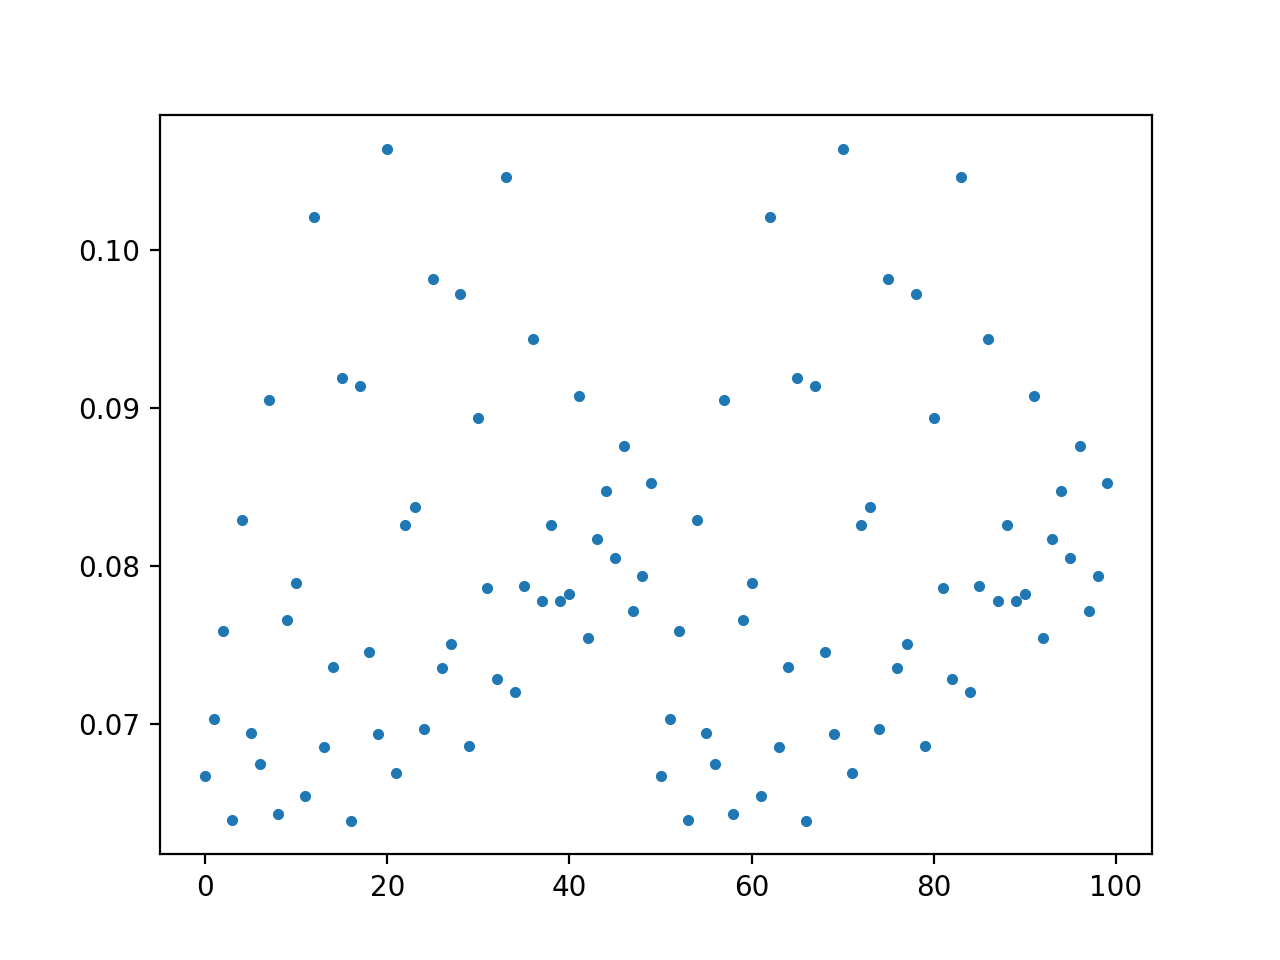

In [45]:
odf_x = odf_interpolator(ref_sl[idx]).squeeze()
plt.plot(odf_x,'.')

# Debug data  generation

In [ ]:
import os, sys

import gym
from gym.spaces import Discrete, Box
import numpy as np

from dipy.data import get_sphere
from dipy.data import HemiSphere, Sphere
from dipy.core.sphere import disperse_charges
import torch


from dfibert.data.postprocessing import res100, resample
from dfibert.data import HCPDataContainer, ISMRMDataContainer, PointOutsideOfDWIError
from dfibert.tracker import StreamlinesFromFileTracker
from dfibert.util import get_grid

import shapely.geometry as geom
from shapely.ops import nearest_points
from shapely.strtree import STRtree


from collections import deque

dataset = HCPDataContainer('100307')
dataset.normalize()

In [ ]:
coord, data = next_state.getCoordinate(), next_state.getValue()
grid = get_grid(np.array([3,3,3]))
ras_points = env.dataset.to_ras(coord)
ras_points = grid + ras_points

interpolated_dwi = env.dataset.get_interpolated_dwi(ras_points, postprocessing=None)
#interpolated_dwi = np.rollaxis(interpolated_dwi,3)

dti_fit = dti_model.fit(interpolated_dwi)
mysphere = get_sphere('repulsion100')
odf = dti_fit.odf(mysphere)

In [ ]:
plt.figure()
plt.plot(range(100), np.mean(odf.reshape(-1,100), axis=0))
plt.plot(range(100), odf[1,1,1,:])

In [ ]:
interpolated_dwi.shape

In [ ]:
states, actions, _, _, _ = agent.replay_memory.get_minibatch()
states = torch.FloatTensor(states).to(agent.device)
predicted_q = torch.argmax(agent.main_dqn(states), dim=1)

false = 0
for i in range(len(actions)):
    if predicted_q[i] != actions[i]:
        false += 1 
    
print("Accuracy =", 1 - false / len(actions))

# Analysis of our environment

In [ ]:
env._get_best_action(None, my_position)

In [ ]:
gt_direction = env.referenceStreamline_ijk.T[:,-1] - env.referenceStreamline_ijk.T[:,-2]
gt_direction = gt_direction / torch.sqrt(torch.sum(gt_direction**2))
gt_direction = gt_direction.view(1,3)

gt_direction

In [ ]:
env.directions[96]

In [ ]:
my_position

In [ ]:
my_position = all_states[0]
eval_steps = 0

current_direction = None
        
if(eval_steps > 0):
    # compute tangent of previous step
    current_direction = all_states[-1] - all_states[-2]
    current_direction = current_direction / torch.sqrt(torch.sum(current_direction**2))
    current_direction = current_direction.view(1,3)

action = env._get_best_action(current_direction, my_position)
action

In [ ]:
# main peak from ODF
peak_dir = env._get_best_action_ODF(my_position)

# cosine similarity wrt. all directions
reward = abs(torch.nn.functional.cosine_similarity(peak_dir.view(1,-1), env.directions))

if(current_direction is not None):
    reward = reward * (torch.nn.functional.cosine_similarity(current_direction, env.directions))

best_action = torch.argmax(reward)
print("Max reward: %.2f" % (torch.max(reward).cpu().detach().numpy()))

In [ ]:
odf_l = torch.from_numpy(env.interpolateODFatState(stateCoordinates=my_position))[:,1,1,1].view(100)
#odf_l = torch.mean(odf_l, 1)
reward = odf_l / torch.max(odf_l)
reward = reward * (torch.nn.functional.cosine_similarity(current_direction, env.directions))
torch.argmax(odf_l), torch.argmax(reward)

In [ ]:
(torch.nn.functional.cosine_similarity(current_direction, env.directions)).shape

In [ ]:
reward.shape

In [ ]:
reward[73]

In [ ]:
fig = plt.figure()
plt.plot(reward.cpu().detach().numpy().squeeze(), '.')

In [ ]:
env.directions

In [ ]:
current_direction

In [ ]:
my_position.cpu().numpy()

In [ ]:
states.T.shape

In [ ]:
k_largest.shape

In [ ]:
np.argmax(my_odf.squeeze())

In [ ]:
all_states

In [ ]:
### visualise streamline
%matplotlib notebook 
state = env.reset(streamline_index=50) 

states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][0:10], env.referenceStreamline_ijk.T[1][0:10], env.referenceStreamline_ijk.T[2][0:10])
ax.plot3D(states.T[0][0:10], states.T[1][0:10], states.T[2][0:10])